# Desalination example

This notebooks illustrates the use of the *PyED* package to simulate the electrodialysis process in action.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Definition-of-electrolytes" data-toc-modified-id="Definition-of-electrolytes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definition of electrolytes</a></span></li><li><span><a href="#Simulation-of-concentration-evolution" data-toc-modified-id="Simulation-of-concentration-evolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulation of concentration evolution</a></span></li><li><span><a href="#Simulation-of-conductivity-evolution" data-toc-modified-id="Simulation-of-conductivity-evolution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation of conductivity evolution</a></span></li><li><span><a href="#Simulation-of-conductivity-with-temperature-dependence" data-toc-modified-id="Simulation-of-conductivity-with-temperature-dependence-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulation of conductivity with temperature-dependence</a></span><ul class="toc-item"><li><span><a href="#Surrogate-model-for-temperature" data-toc-modified-id="Surrogate-model-for-temperature-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Surrogate model for temperature</a></span></li><li><span><a href="#The-non-linear-temperature-correction" data-toc-modified-id="The-non-linear-temperature-correction-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>The non-linear temperature correction</a></span></li></ul></li><li><span><a href="#Simulation-of-conductivity" data-toc-modified-id="Simulation-of-conductivity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Simulation of conductivity</a></span></li><li><span><a href="#Experimental-validation" data-toc-modified-id="Experimental-validation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Experimental validation</a></span><ul class="toc-item"><li><span><a href="#Conductivity" data-toc-modified-id="Conductivity-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Conductivity</a></span></li><li><span><a href="#Resistance" data-toc-modified-id="Resistance-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Resistance</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

Since this is a local package we first need to define the path to the *PyED* package

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../PyED'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

Let's import some useful libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Now the package can be imported,

In [3]:
from PyED import Electrolyte, Reservoir, Channel

## Definition of electrolytes
The first step is defining the different electrolytes to be used in the setup. We will use two Na2SO4 for the electrolyte rinsing solution and NaCl for the diluate and concentrate compartments

In [4]:
NaCl = Electrolyte(lambdaEq=10.53e-3)     # Define sodium chloride with a conductivity of 10.53e-3 (mS/cm)
Na2SO4 = Electrolyte(lambdaEq=25.982e-3)   # Define sodium sulfate with a conductivity of 25.982e-3 (mS/cm)

## Simulation of concentration evolution
The setup is a batch ED setup with one concentrate, diluate and electrolyte rinsing reservoir. First the different reservoirs are constructed from the *Reservoir* class

In [5]:
diluateRes = Reservoir(volume=1e-3,           # volume of diluate reservoir (m3)
                    concentration = 0.1*1000,  # initial concentration of salt  (mol.m-3)
                    electrolyte=NaCl)   

concentrateRes = Reservoir(volume=1e-3,           # volume of diluate reservoir (m3)
                    concentration = 0.1*1000,     # initial concentration of salt  (mol.m-3)
                    electrolyte=NaCl)   

ERSRes = Reservoir(volume=1e-3,                   # volume of diluate reservoir (m3)
                    concentration = 0.1*1000,     # initial concentration of salt  (mol.m-3)
                    electrolyte=Na2SO4)   


The flux that is transported between these reservoirs can be computed as follows,

$$J_m = \cfrac{\epsilon\,i}{F}$$

with $J_m$ the flux of salt (mol/s),the current efficiency  $\epsilon$ (-) , $i$ the electric current (A or C/s) and $F$ Faraday's constant (C/mol).

In [6]:
epsilon = 0.9
current = 1.0
F = 96485.33 

In [7]:
Jm = epsilon*current/F 

The time-evolution of the reservoirs affected by the flux can be computed through the *timeLoop()* function of the *Reservoir* class instance. It is assumed that the reservoirs are continuously-stirred tanks and a mass balance over each reservoir leads to,

$$change of mass = in - out + accumulation \, ,$$

$$\cfrac{\mathrm{d}M}{\mathrm{d}t} = \cfrac{ \epsilon\,i}{F} $$

$$\cfrac{\mathrm{d}(C\,V)}{\mathrm{d}t} = \cfrac{ \epsilon\,i}{F} $$

$$\cfrac{\mathrm{d}C}{\mathrm{d}t} = \cfrac{ \epsilon\,i}{F\,V} $$

Integration of this equation leads to,

$$ C_t =  C_0 - t\,\cfrac{i}{F\, V}  $$

which is implemented as the *timeLoop()* method of the *Reservoir* class.



In [8]:
tEnd = 160*60 # (s)
time = np.linspace(0,tEnd, 40)

In [9]:
CDil = diluateRes.timeLoop(Jm, time)
CCon = concentrateRes.timeLoop(-Jm, time)
CERS = ERSRes.timeLoop(0.0, time)

After computing the concentration evolution in each channel, it can be visualised

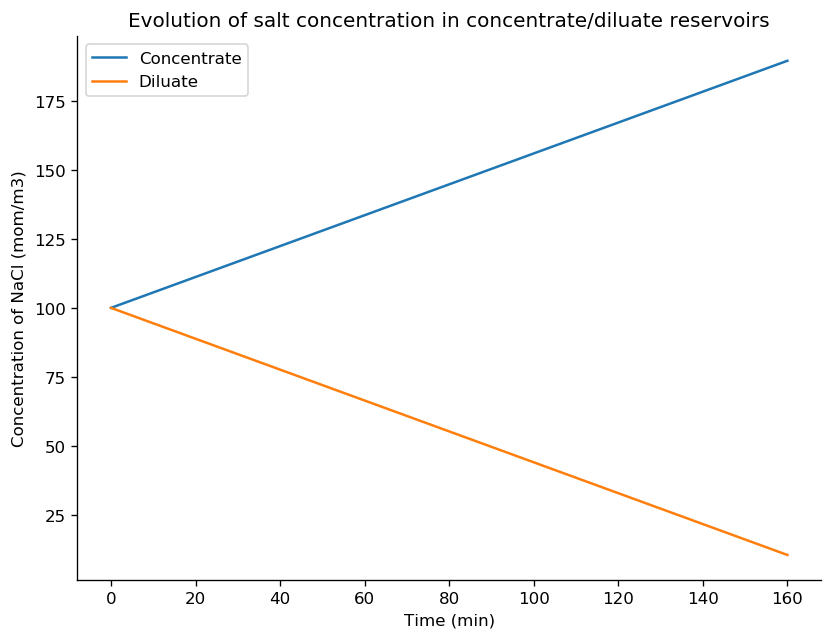

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=120)

plt.plot(time/60, CCon, time/60, CDil)
plt.xlabel("Time (min)")
plt.ylabel("Concentration of NaCl (mom/m3)")
plt.legend(["Concentrate", "Diluate"], loc=0)
plt.title("Evolution of salt concentration in concentrate/diluate reservoirs")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

With the concentration profiles predicted, it is time to move on predicting the conductivity

## Simulation of conductivity evolution

Assuming a constant molar conductivity of NaCl and Na2SO4, which is not entirely true [1]. The conductivity $\kappa$ is computed by plugging the concentration arrays into the *conductivity*-method, 

$$\kappa = \Lambda_m\, c$$

with $\Lambda_m$ the molar conductivity and $c$ the concentration of a certain electrolyte

In [11]:
kappaDil = diluateRes.conductivity(CDil)*10  # times 10 to convert to mS/cm
kappaCon = concentrateRes.conductivity(CCon)*10
kappaERS = ERSRes.conductivity(CERS)*10

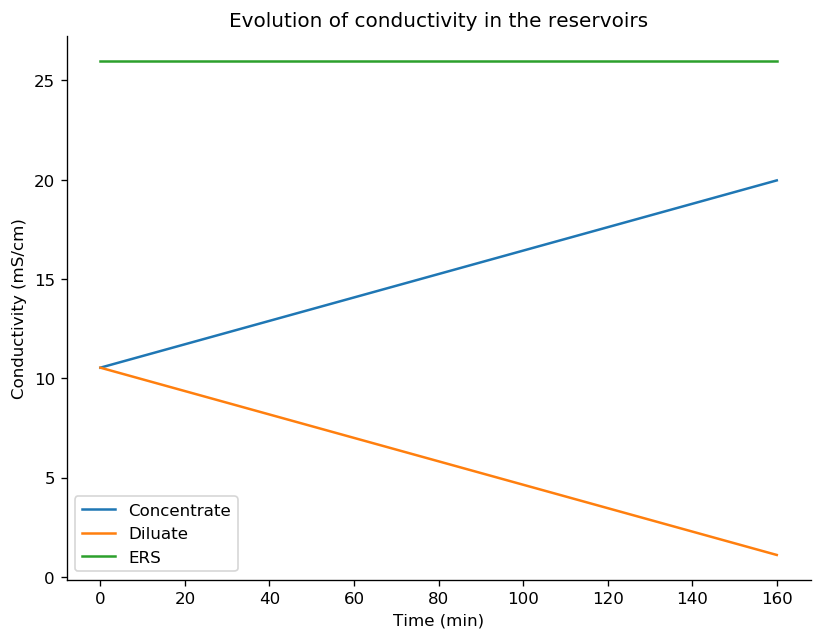

In [12]:
plt.figure(num=None, figsize=(8, 6), dpi=120)

plt.plot(time/60, kappaCon, time/60, kappaDil, time/60, kappaERS)

plt.xlabel("Time (min)")
plt.ylabel("Conductivity (mS/cm)")
plt.legend(["Concentrate", "Diluate", "ERS"], loc=0)
plt.title("Evolution of conductivity in the reservoirs")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Simulation of conductivity with temperature-dependence

The conductivity depends on the temperature and by applying a non-linear temperature compensation to the conductivity prediction one can greatly improve the accuracy of the prediction

###  Surrogate model for temperature

To take into effect the temperature evolution a polynomial is fit to the data of a typical temperature profile during the ED experiments. The *poly1D* functionality is used from *Numpy* to fit a 2nd order polynomial to the temperature data

In [13]:
timeExp = np.array([0,
    1500,
    3000,
    4500,
    6000,
    7500,
    9000,
    10500])

T1 = np.array([
    21.75,
    23,
    24,
    24.75,
    25.25,
    26,
    26.25,
    26.5])

In [14]:
temperatureModel = np.poly1d(np.polyfit(timeExp, T1, 2)) # fitting a 2th order polynomial to the data

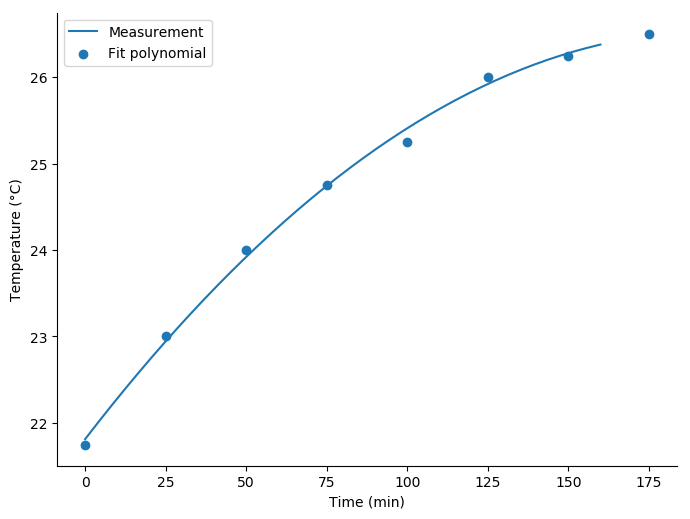

In [15]:
plt.figure(num=None, figsize=(8, 6), dpi=100)

ax = plt.gca()
ax.scatter(timeExp/60, T1)
ax.plot(time/60, temperatureModel(time))


ax.set_xlabel("Time (min)")
ax.set_ylabel("Temperature (°C)")
plt.legend(["Measurement", "Fit polynomial"], loc=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### The non-linear temperature correction

The non-linear temperature correction is used from this paper [2].

$$\Lambda_{m,T} = \left(\Lambda_{m,25}- 0.0545 \right)\,\left( 1 + 0.02\,\left(T-25 \right) \right) + \Lambda_{w,T}$$

with $\Lambda_{m,T}$ the molar conductivity of the electrolyte at temperature $T$ ($^\circ$C),  $\Lambda_{m,25}$ the conductivity at 25\,$^\circ$C (tables) and $\Lambda_{w,T}$ the conductivity of pure water at temperature $T$. For the latter the following correlation with the temperature is used,

$$\Lambda_{w,T} = 0.0545\left(0.55\,e^{0.0363\,T} - 0.356 \right)$$

This is implemented in the *conductivityTemp()* method

In [16]:
temperature = temperatureModel(time)
kappaDilComp = diluateRes.conductivityTemp(CDil, temperature)*10  # times 10 to convert to mS/cm
kappaConComp = concentrateRes.conductivityTemp(CCon, temperature)*10
kappaERSComp = ERSRes.conductivityTemp(CERS, temperature)*10

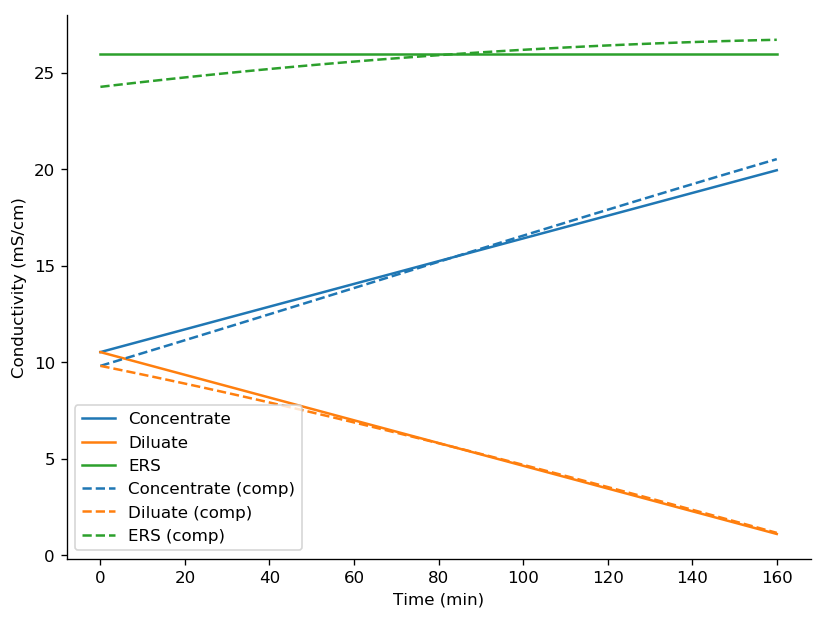

In [17]:
plt.figure(num=None, figsize=(8, 6), dpi=120)
ax = plt.gca()
ax.plot(time/60,  kappaCon, time/60, kappaDil, time/60, kappaERS)
plt.gca().set_prop_cycle(None)
ax.plot(time/60,  kappaConComp, time/60, kappaDilComp, time/60, kappaERSComp, ls='dashed')


ax.set_xlabel("Time (min)")
ax.set_ylabel("Conductivity (mS/cm)")
plt.legend([ "Concentrate", "Diluate", "ERS", "Concentrate (comp)", "Diluate (comp)", "ERS (comp)"], loc=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Simulation of conductivity

Now that the conductivity can be simulated in the ED system, The final step is to simulate the stack resistance $R_t$ the stack (our stack has one cell pair), 

$$R_t = R_{er} + 2\,R_e + U_{D}\,i + R_c + R_d + 2\,R_{CEM} + R_{AEM} $$

with 
* $R_{er}$ the resistance due to electrode reaction
* $R_{e}$ the electrolytic resistance of the electrode rinsing solution
* $U_{D}$ the Donnan potential, but the net-effect is zero so this can be removed
* $R_{c}$ the electrolytic resistance of the concentrate channel
* $R_{d}$ the electrolytic resistance of the diluate channel
* $R_{CEM}$ the resistance of the CEM
* $R_{AEM}$ the resistance of the AEM

$R_{er}$ is very hard to estimate but since this is the only parameter left undetermined, it can easily be estimated from the data

$R_e$, $R_c$, $R_d$ follow from the conductivity computed earlier,

$$R_x = \cfrac{w}{\kappa\, A_m \, A_s}$$

with $w$ the channel thickness, $A_m$ the membrane surface and $A_s$ the fraction of the membrane that is not blocked by spacers. Image analysis showed that for our spacers this is about 85%. This equation is implemented as the *resistance()*-function defined below. Finally, the resistance of the IEMs is obtained from the manufacturer.

In [18]:
def resistance(w, kappa, Am, As):
    return w/(kappa*Am*As)

In [19]:
w = 3e-3
Am = 4e-2*50e-2          # membrane surface
As = 0.85                # obtained from image analysis
RCEM = 1.125/(Am*10**4)
RAEM = 1.25/(Am*10**4)

**Resistance without electrode reaction constant**

In [20]:
RDil = resistance(w, kappaDil/10, Am, As) # divided by then to go from mS/cm to S/m
RCon = resistance(w, kappaCon/10, Am, As)
RErs = resistance(w, kappaERS/10, Am, As)
Rt = RDil + RCon + 2*RErs + 2*RCEM + RAEM

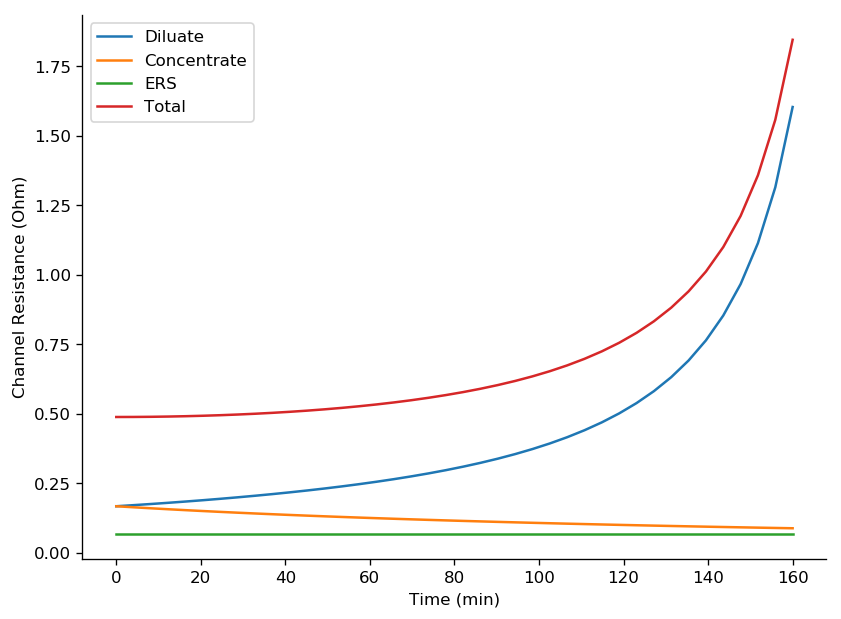

In [21]:
plt.figure(num=None, figsize=(8, 6), dpi=120)
ax = plt.gca()

ax.plot(time/60, RDil, time/60, RCon, time/60, RErs, time/60, Rt)

ax.set_xlabel("Time (min)")
ax.set_ylabel("Channel Resistance (Ohm)")
plt.legend(["Diluate", "Concentrate", "ERS", "Total"], loc=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

**Resistance with electrode reaction constant**
The baseline resistance can be increased by "calibrating" the Resistance of the electrode reactions.

In [22]:
Rer = 3.0                # change this to fit the initial resistance

In [23]:
RDil = resistance(w, kappaDil/10, Am, As)
RCon = resistance(w, kappaCon/10, Am, As)
RErs = resistance(w, kappaERS/10, Am, As)
Rt = RDil + RCon + 2*RErs + 2*RCEM + RAEM + Rer

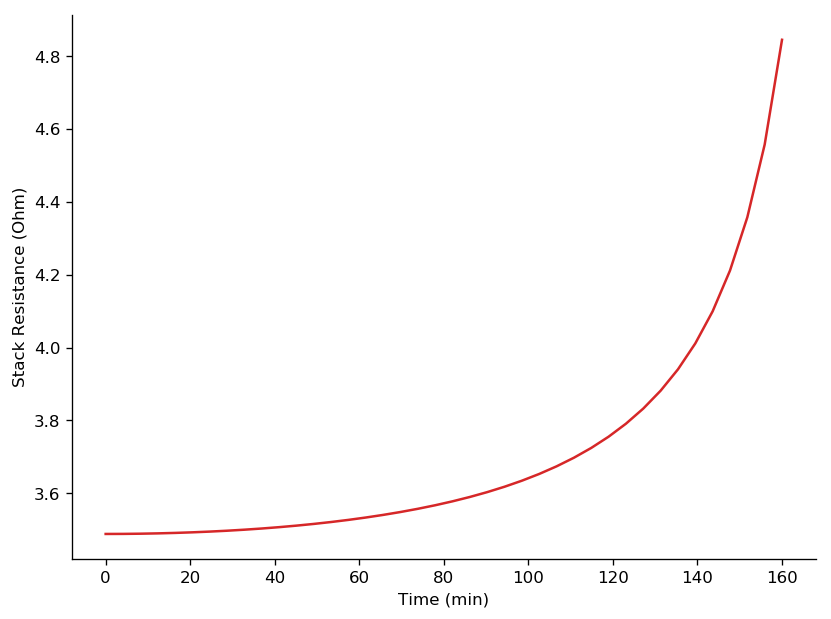

In [24]:
plt.figure(num=None, figsize=(8, 6), dpi=120)
ax = plt.gca()

ax.plot(time/60, Rt, c="#D62728")

ax.set_xlabel("Time (min)")
ax.set_ylabel("Stack Resistance (Ohm)")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Experimental validation
The conductivity prediction and Stack resistance prediction can be compared to experimental data

### Conductivity

### Resistance

## References
[1] [White paper: Reducing Common Errors in Conductivity Measurements](https://www.mt.com/dam/MT-NA/pHCareCenter/Conductivity_Reduce_Common_Errors_WP.pdf)

[2] [Cation conductivity temperature compensation](https://www.mt.com/dam/mt_ext_files/Editorial/Generic/4/Paper-THOR-Cation-Cond-Temp-Bev-Gray-11-97_Editorial-Generic_1161617581924_files/cation_cond_tempcompensation.pdf)